In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

CIFAR-10 shapes:
  x_train: (45000, 32, 32, 3)
  x_val:   (5000, 32, 32, 3)
  x_test:  (10000, 32, 32, 3)
Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0279 - val_loss: 0.0109
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0092 - val_loss: 0.0082
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 11/50
352/35

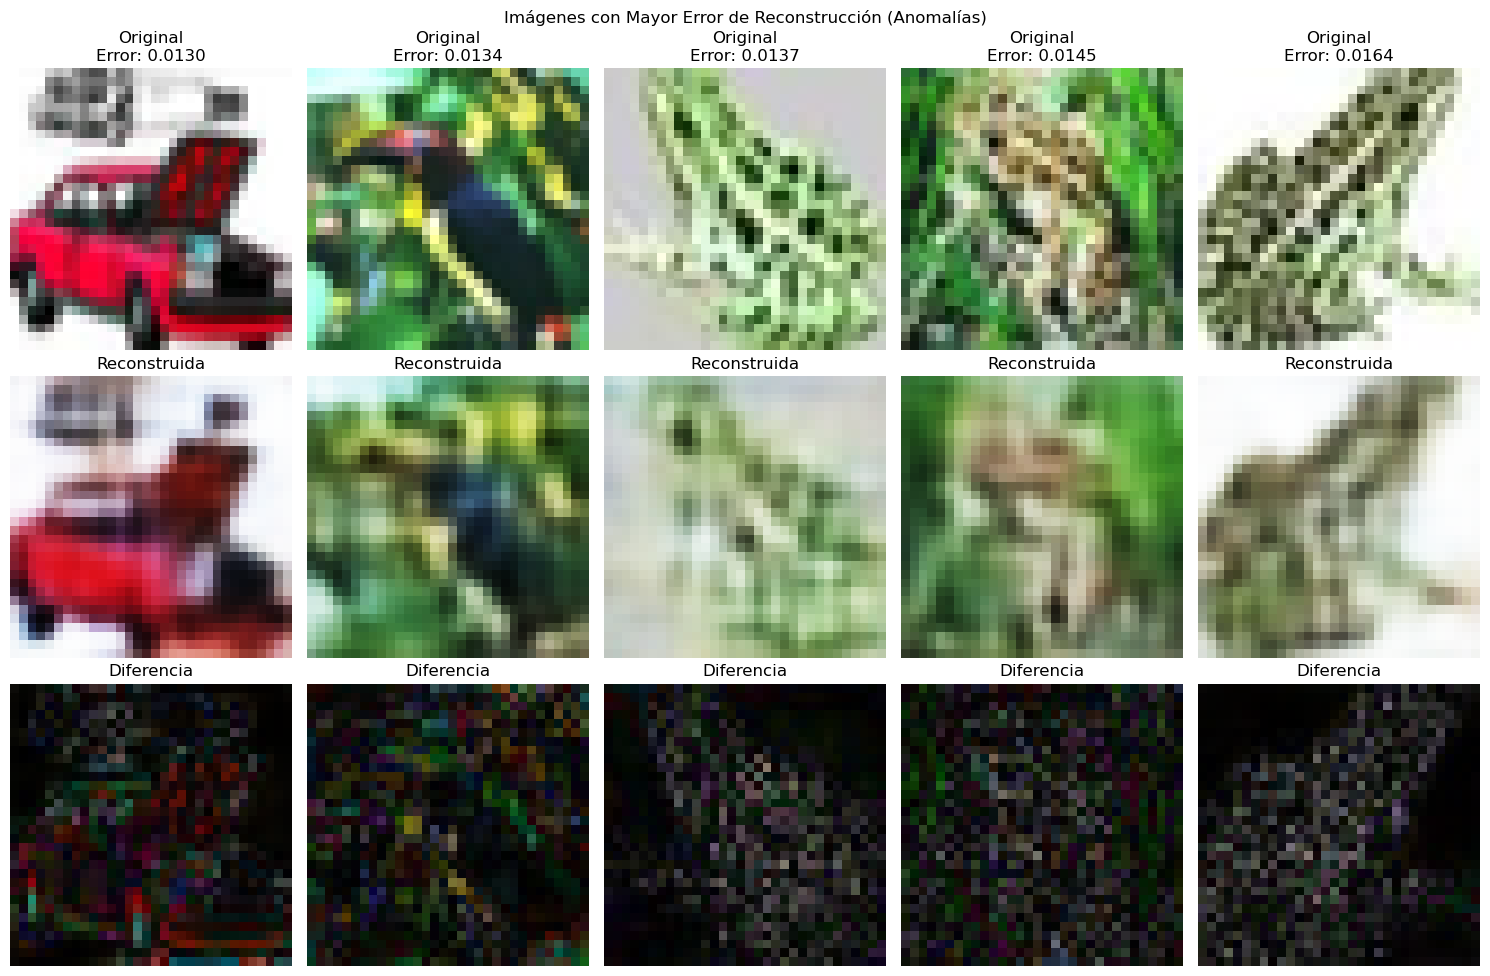

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_val = x_train[-5000:]
x_train = x_train[:-5000]

print("CIFAR-10 shapes:")
print("  x_train:", x_train.shape)
print("  x_val:  ", x_val.shape)
print("  x_test: ", x_test.shape)

def add_noise(data, noise_factor=0.1):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0.0, 1.0)

x_train_noisy = add_noise(x_train, noise_factor=0.1)
x_val_noisy = add_noise(x_val, noise_factor=0.1)
x_test_noisy = add_noise(x_test, noise_factor=0.1)

def build_denoising_autoencoder(input_shape=(32, 32, 3)):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Capa latente
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    latent = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(latent)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(inputs, outputs, name="denoising_autoencoder")
    return model

# Entrenamiento
den_autoencoder = build_denoising_autoencoder()
den_autoencoder.compile(optimizer='adam', loss='mse')

EPOCHS = 50
BATCH_SIZE = 128

den_autoencoder.fit(
    x_train_noisy, x_train,
    validation_data=(x_val_noisy, x_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# errores de reconstrucción en el conjunto de prueba
reconstructed_images = den_autoencoder.predict(x_test_noisy)
reconstruction_errors = np.mean((x_test - reconstructed_images) ** 2, axis=(1, 2, 3))

num_anomalies = 5
anomaly_indices = np.argsort(reconstruction_errors)[-num_anomalies:]
anomalous_images = x_test[anomaly_indices]
anomalous_reconstructions = reconstructed_images[anomaly_indices]
anomaly_errors = reconstruction_errors[anomaly_indices]

plt.figure(figsize=(15, 10))

for i in range(num_anomalies):
    ax = plt.subplot(3, num_anomalies, i + 1)
    plt.imshow(anomalous_images[i])
    plt.title(f"Original\nError: {anomaly_errors[i]:.4f}")
    plt.axis("off")

for i in range(num_anomalies):
    ax = plt.subplot(3, num_anomalies, num_anomalies + i + 1)
    plt.imshow(anomalous_reconstructions[i])
    plt.title("Reconstruida")
    plt.axis("off")

for i in range(num_anomalies):
    ax = plt.subplot(3, num_anomalies, 2 * num_anomalies + i + 1)
    diff = np.abs(anomalous_images[i] - anomalous_reconstructions[i])
    plt.imshow(diff)
    plt.title("Diferencia")
    plt.axis("off")

plt.suptitle("Imágenes con Mayor Error de Reconstrucción (Anomalías)")
plt.tight_layout()
plt.show()

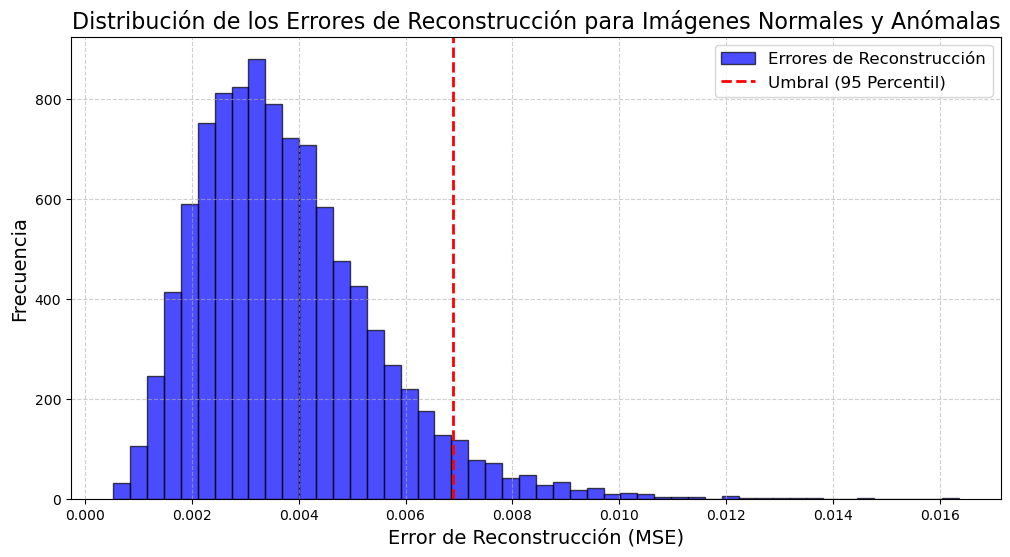

In [4]:
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7, edgecolor='black', label='Errores de Reconstrucción')
plt.title("Distribución de los Errores de Reconstrucción para Imágenes Normales y Anómalas", fontsize=16)
plt.xlabel("Error de Reconstrucción (MSE)", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.axvline(x=np.percentile(reconstruction_errors, 95), color='red', linestyle='--', linewidth=2, label='Umbral (95 Percentil)')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()